In [1]:
import cvxpy as cvx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import math

In [2]:
#Generator's parameters
Gen = pd.DataFrame.from_dict({
    'g1': [18, 400, 100, 5.47, 0, 0, 47, 47, 105, 108, 1, 1, 1, 5, 0], 
    'g2': [21, 400, 100, 5.47, 0, 0, 47, 47, 106, 112, 1, 1, 1, 6, 0],
    'g3': [1, 152, 30.4, 13.32, 1430.4, 1430.4, 14, 14, 43, 45, 8, 4, 1, 2, 0],
    'g4': [2, 152, 30.4, 13.32, 1430.4, 1430.4, 14, 14, 44, 57, 8, 4, 1, 2, 0],
    'g5': [15, 155, 54.25, 16, 0, 0, 21, 21, 65, 77, 8, 8, 0, 0, 2],
    'g6': [16, 155, 54.25, 10.52, 312, 312, 21, 21, 66, 73, 8, 8, 1, 10, 0],
    'g7': [23, 310, 108.5, 10.52, 624, 624, 21, 21, 112, 125, 8, 8, 1, 10, 0],
    'g8': [23, 350, 140, 10.89, 2298, 2298, 28, 28, 154, 162, 8, 8, 1, 5, 0],
    'g9': [7, 350, 75, 20.7, 1725, 1725, 49, 49, 77, 80, 8, 8, 0, 0, 2],
    'g10': [13, 591, 206.85, 20.93, 3056.7, 3056.7, 21, 21, 213, 228, 12, 10, 0, 0, 8],
    'g11': [15, 60, 12, 26.11, 437, 437, 7, 7, 19, 31, 4, 2, 0, 0, 1],
    'g12': [22, 300, 0, 0, 0, 0, 35, 35, 315, 326, 0, 0, 1, 2, 0],

}, 
    orient='index', columns=['Bus','Pmax','Pmin','b', 'Cs', 'Cd','RU','RD','SU','SD','UT','DT','u','U0','S0']);

Gen

,Bus,Pmax,Pmin,b,Cs,Cd,RU,RD,SU,SD,UT,DT,u,U0,S0
g1,18,400,100.00,5.47,0.0,0.0,47,47,105,108,1,1,1,5,0
g2,21,400,100.00,5.47,0.0,0.0,47,47,106,112,1,1,1,6,0
g3,1,152,30.40,13.32,1430.4,1430.4,14,14,43,45,8,4,1,2,0
g4,2,152,30.40,13.32,1430.4,1430.4,14,14,44,57,8,4,1,2,0
g5,15,155,54.25,16.00,0.0,0.0,21,21,65,77,8,8,0,0,2
g6,16,155,54.25,10.52,312.0,312.0,21,21,66,73,8,8,1,10,0
g7,23,310,108.50,10.52,624.0,624.0,21,21,112,125,8,8,1,10,0
g8,23,350,140.00,10.89,2298.0,2298.0,28,28,154,162,8,8,1,5,0
g9,7,350,75.00,20.70,1725.0,1725.0,49,49,77,80,8,8,0,0,2
g10,13,591,206.85,20.93,3056.7,3056.7,21,21,213,228,12,10,0,0,8


In [3]:
Data = pd.DataFrame.from_dict({
    'Wind':[0,0,0,0,0,0,0,200,0,0,0,0,0,0,0,0,0,0,150,0,100,0,0,0],
    'SOC':[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,200,0,100,0,0,0],
},
    orient='columns')
Data

,Wind,SOC
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,200,0
8,0,0
9,0,0


In [4]:
BranchData = pd.DataFrame.from_dict({
    'From':[1,1,1,2,2,3,3,4,5,6,7,8,8,9,9,10,10,11,11,12,12,13,14,15,15,15,16,16,17,17,18,19,20,21],
    'To':[2,3,5,4,6,9,24,9,10,10,8,9,10,11,12,11,12,13,14,13,23,23,16,16,21,24,17,19,18,22,21,20,23,22],
    'r':[0.0026,0.0546,0.0218,0.0328,0.0497,0.0308,0.0023,0.0268,0.0228,0.0139,0.0159,0.0427,0.0427,0.0023,0.0023,0.0023,0.0023,0.0061,0.0054,0.0061,0.0124,0.0111,0.0050,0.0022,0.0032,0.0067,0.0033,0.0030,0.0018,0.0135,0.0017,0.0026,0.0014,0.0087],
    'x':[0.0139,0.2112,0.0845,0.1267,0.1920,0.1190,0.0839,0.1037,0.0883,0.0605,0.0614,0.1651,0.1651,0.0839,0.0839,0.0839,0.0839,0.0476,0.0418,0.0476,0.0966,0.0865,0.0389,0.0173,0.0245,0.0519,0.0259,0.0231,0.0144,0.1053,0.0130,0.0198,0.0108,0.0678],
    'b':[0.4611,0.0572,0.0229,0.0343,0.0520,0.0322,0.0000,0.0281,0.0239,2.4590,0.0166,0.0447,0.0447,0.0000,0.0000,0.0000,0.0000,0.0999,0.0879,0.0999,0.2030,0.1818,0.0818,0.0364,0.2060,0.1091,0.0545,0.0485,0.0303,0.2212,0.1090,0.1666,0.0910,0.1424],
    'Limit':[175,175,175,175,175,175,400,175,175,175,175,175,175,400,400,400,400,500,500,500,500,500,500,500,1000,500,500,500,500,500,1000,1000,1000,500],
},
    orient='columns')
BranchData


,From,To,r,x,b,Limit
0,1,2,0.0026,0.0139,0.4611,175
1,1,3,0.0546,0.2112,0.0572,175
2,1,5,0.0218,0.0845,0.0229,175
3,2,4,0.0328,0.1267,0.0343,175
4,2,6,0.0497,0.1920,0.0520,175
5,3,9,0.0308,0.1190,0.0322,175
6,3,24,0.0023,0.0839,0.0000,400
7,4,9,0.0268,0.1037,0.0281,175
8,5,10,0.0228,0.0883,0.0239,175
9,6,10,0.0139,0.0605,2.4590,175


In [5]:
WD = pd.DataFrame.from_dict({
    'w':[0.0786666666666667,0.0866666666666667,0.117333333333333,0.258666666666667,0.361333333333333,0.566666666666667,0.650666666666667,0.566666666666667,0.484,0.548,0.757333333333333,0.710666666666667,0.870666666666667,0.932,0.966666666666667,1,0.869333333333333,0.665333333333333,0.656 ,0.561333333333333,0.565333333333333,0.556,0.724,0.84],
    'd':[0.684511335492475,0.644122690036197,0.61306915602972,0.599733282530006,0.588874071251667,0.5980186702229,0.626786054486569,0.651743189178891,0.706039245570585,0.787007048961707,0.839016955610593,0.852733854067441,0.870642027052772,0.834254143646409,0.816536483139646,0.819394170318156,0.874071251666984,1,0.983615926843208,0.936368832158506,0.887597637645266,0.809297008954087,0.74585635359116,0.733473042484283],
},
    orient='columns')
WD

,w,d
0,0.078667,0.684511
1,0.086667,0.644123
2,0.117333,0.613069
3,0.258667,0.599733
4,0.361333,0.588874
5,0.566667,0.598019
6,0.650667,0.626786
7,0.566667,0.651743
8,0.484000,0.706039
9,0.548000,0.787007


In [6]:
BusData = pd.DataFrame.from_dict({
    'Pd':[108,97,180,74,71,136,125,171,175,195,0,0,265,194,317,100,0,333,181,128,0,0,0,0],
    'Qd':[22,20,37,15,14,28,25,35,36,40,0,0,54,39,64,20,0,68,37,26,0,0,0,0],
},
    orient='columns')
BusData

,Pd,Qd
0,108,22
1,97,20
2,180,37
3,74,15
4,71,14
5,136,28
6,125,25
7,171,35
8,175,36
9,195,40


In [70]:
T = len(WD.index) #time samples
Gen_num = len(Gen.index) #number of generators
l = len(BranchData.index) # number of branches
n = len(BusData.index) #number of buses
Sbase = 100
VOLL = 10000 #Value of loss of load ($/MW h)
VOLW = 50 #Value of loss of wind ($/MW h)
#ESS parameters
SOC_0 = 0.2*Data.loc[:,'SOC'].values/Sbase;
SOC_max = Data.loc[:,'SOC'].values/Sbase;
SOC_min = 0.2*SOC_max
Pd_max = 0.2*SOC_max; #Discharge limits
Pd_min = 0;
Pc_max = 0.2*SOC_max; #Charge limits
Pc_min = 0;
eta_c = 0.95; #Charge efficiency
eta_d = 0.9; #Discharge efficiency
Slack_bus = 13 #Number of the slack bus



In [71]:
#Variables
Pg = cvx.Variable((Gen_num,T)) #Generated power (g1,g2,g3,g4)
Pij = cvx.Variable((l,T)) #Power flow
delta = cvx.Variable((n,T)) #Voltage Angle
Ls = cvx.Variable((n,T)) #Load shedding
SOC = cvx.Variable((n,T)) #State of charge
Pd = cvx.Variable((n,T)) #Discharge power
Pc = cvx.Variable((n,T)) #Charge power
Pw = cvx.Variable((n,T)) #Active Wind power
Pwc = cvx.Variable((n,T)) #Curtailed wind power

Pg_min = Gen.loc[:,'Pmin'].values/Sbase #Power generation limits
Pg_max = Gen.loc[:,'Pmax'].values/Sbase
RU = Gen.loc[:,'RU'].values/Sbase #RampUp
RD = Gen.loc[:,'RD'].values/Sbase #RampDown

Pl = BusData.loc[:,'Pd'].values/Sbase #Load

Pw_min = 0 #Active power limits for wind turbine
Pw_max = Data.loc[:,'Wind'].values/Sbase 
Pwc_min = 0 #Curtailed power limits for wind turbine
Pwc_max = Data.loc[:,'Wind'].values/Sbase

Ls_min = 0 # Limits of load shedding
Ls_max = BusData.loc[:,'Pd'].values/Sbase

Wind = Data.loc[:,'Wind'].values/Sbase #Wind power


A = np.eye(Gen_num)



In [78]:
samples = []
for t in range(T):
    cost = sum(Gen.loc[:,'b'].values*A*Pg[:,t]*Sbase) + sum(VOLL*Ls[:,t]*Sbase) + sum(VOLW*Pwc[:,t]*Sbase) #Generation cost/ objective function
    
    if t == 0:
        constr = [SOC[:,t] == SOC_0 + Pc[:,t]*eta_c - Pd[:,t]/eta_d] #State of charge
    else:
        constr = [Pg[:,t] - Pg[:,t-1] <= RU, #RampUp
                  Pg[:,t-1] - Pg[:,t] <= RD, #RampDown
                  SOC[:,t] == SOC[:,t-1] + Pc[:,t]*eta_c - Pd[:,t]/eta_d #State of charge
                  ] 
#DC-OPF    
    for i in range(n):
        Pg_sum = 0 #summation of power generation in the node
        Pij_sum = 0 #summation of the power line flow in the node
        y = 0
        for j in range(n):
            for z in BranchData.index:
                if BranchData.loc[z,'From'] == i+1:
                    Pij_sum += Pij[z,t]
                if BranchData.loc[z,'To'] == i+1:
                    Pij_sum -= Pij[z,t]
                
                if ((BranchData.loc[z,'From'] == i+1) & (BranchData.loc[z,'To'] == j+1)):
                    constr.extend([Pij[z,t] == (delta[i,t]-delta[j,t])/BranchData.loc[z,'x'],
                                  Pij[z,t] >= -BranchData.loc[z,'Limit'],
                                  Pij[z,t] <= BranchData.loc[z,'Limit'],
                                  ]) 
        for x in Gen.index:
            if Gen.loc[x,'Bus'] == i+1:
                    Pg_sum += Pg[y,t]
            y += 1
                          
    
        constr.extend([Pij_sum == Pg_sum + Ls[i,t] + Pw[i,t] - Pl[i]*WD.loc[t,'d'] - Pc[i,t] + Pd[i,t]]) #Power balance
        
        if i+1 == T:
             constr.extend([SOC[:,i] == SOC_0])
            
        
        if i+1 == Slack_bus:
            constr.extend([delta[i,t] == 0])


        
    constr.extend([SOC[:,t] >= SOC_min, #Battery's charge limits
                  SOC[:,t] <= SOC_max,
                  Pd[:,t] >= Pd_min, #Discharge limits
                  Pd[:,t] <= Pd_max,
                  Pc[:,t] >= Pc_min, #Charge limits
                  Pc[:,t] <= Pc_max, 
                  Pg[:,t] >= Pg_min, #Generation limits
                  Pg[:,t] <= Pg_max, 
                  Pw[:,t] >= Pw_min, #Wind power limits
                  Pw[:,t] <= Pw_max*WD.loc[t,'w'],
                  Pwc[:,t] >= Pwc_min, #Curtailed wind power limits
                  Pwc[:,t] <= Pwc_max*WD.loc[t,'w'],
                  Ls[:,t] >= Ls_min, #Limits of load shedding
                  Ls[:,t] <= Ls_max*WD.loc[t,'d'],
                  delta[:,t] >= -math.pi, #limits of Voltage angle
                  delta[:,t] <= math.pi,
                  Pw[:,t] + Pwc[:,t] <= WD.loc[t,'w']*Wind, #Wind balance
                  ]) 
    
    samples.append(cvx.Problem(cvx.Minimize(cost), constr))
prob = sum(samples)

#prob.constraints += [SOC[:,T-1] == SOC_0] #???
OV = prob.solve(solver=cvx.GLPK_MI) #Value of objective function
#OV = prob.solve()

C:\Users\maxel\Anaconda3\lib\site-packages\cvxpy-1.0.6-py3.6-win-amd64.egg\cvxpy\problems\problem.py:613: RuntimeWarning: overflow encountered in long_scalars
  if self.max_big_small_squared < big*small**2:


In [79]:
P_sum = sum(Pg.value)
P_f = Pg.value
OV

418089.8421095523

In [89]:
SOC_sum = sum(SOC.value)
SOC_f = SOC.value



In [81]:
Pd_sum = sum(Pd.value)
Pc_sum = sum(Pc.value)
Pd_f = Pd.value
Pc_f = Pc.value

In [82]:
Pw_sum = sum(Pw.value)


In [83]:
Pl_sum = sum(Pl)*WD.loc[:,'d']


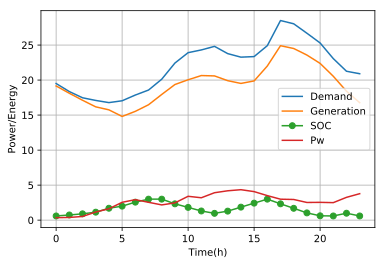

In [84]:
plt.figure()
plt.plot(Pl_sum,label="Demand") 
plt.plot(P_sum,label="Generation") 
plt.plot(SOC_sum,label="SOC",marker = 'o') 
plt.plot(Pw_sum,label="Pw")
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy')
plt.legend(loc='right')
plt.grid()


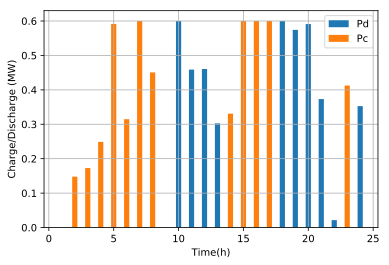

In [90]:
x = range(1,T+1)
plt.figure()
 
plt.bar(x,Pd_sum.flatten(),label="Pd", width = 0.4) 
plt.bar(x,Pc_sum.flatten(),label="Pc", width = 0.4) 
plt.xlabel('Time(h)')
plt.ylabel('Charge/Discharge (MW)')
plt.legend(loc='upper right')
plt.grid()

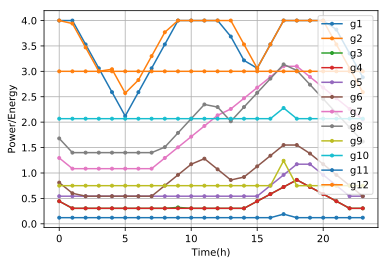

In [91]:
plt.figure()
plt.plot(P_f[0,:],label="g1", marker = '.') 
plt.plot(P_f[1,:],label="g2", marker = '.') 
plt.plot(P_f[2,:],label="g3", marker = '.')
plt.plot(P_f[3,:],label="g4", marker = '.')
plt.plot(P_f[4,:],label="g5", marker = '.')
plt.plot(P_f[5,:],label="g6", marker = '.')
plt.plot(P_f[6,:],label="g7", marker = '.')
plt.plot(P_f[7,:],label="g8", marker = '.')
plt.plot(P_f[8,:],label="g9", marker = '.')
plt.plot(P_f[9,:],label="g10", marker = '.')
plt.plot(P_f[10,:],label="g11", marker = '.')
plt.plot(P_f[11,:],label="g12", marker = '.')
plt.xlabel('Time(h)')
plt.ylabel('Power/Energy')
plt.legend(loc='upper right')
plt.grid()

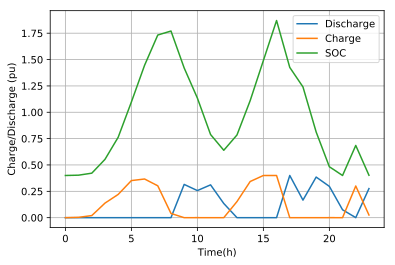

In [65]:
plt.figure()
 
plt.plot(Pd_f[18,:],label="Discharge") 
plt.plot(Pc_f[18,:],label="Charge") 
plt.plot(SOC_f[18,:],label="SOC") 
plt.xlabel('Time(h)')
plt.ylabel('Charge/Discharge (pu)')
plt.legend(loc='upper right')
plt.grid()

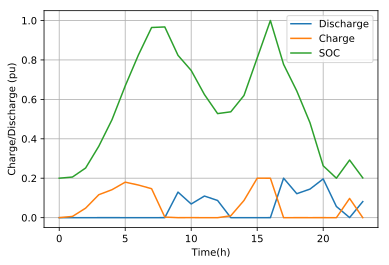

In [66]:
plt.figure()
 
plt.plot(Pd_f[20,:],label="Discharge") 
plt.plot(Pc_f[20,:],label="Charge") 
plt.plot(SOC_f[20,:],label="SOC") 
plt.xlabel('Time(h)')
plt.ylabel('Charge/Discharge (pu)')
plt.legend(loc='upper right')
plt.grid()

In [77]:
delta.value


array([[-3.139712  , -3.14066844, -3.14115664, -3.14135434, -3.14139655,
        -3.14150751, -3.14151127, -3.14148696, -3.14148224, -3.14146186,
        -3.14146537, -3.14146259, -3.14146521, -3.14147693, -3.1414881 ,
        -3.14150405, -3.14107701, -3.1407392 , -3.13995404, -3.14021043,
        -3.14087213, -3.14125227, -3.14149362, -3.14150058],
       [-3.13982509, -3.14078276, -3.14125928, -3.14144569, -3.14148065,
        -3.14158368, -3.14159265, -3.14158098, -3.14159265, -3.14159265,
        -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
        -3.14159265, -3.14117583, -3.14085752, -3.14007305, -3.14033368,
        -3.14099458, -3.14136526, -3.14159265, -3.14159265],
       [-3.13495368, -3.13562324, -3.13659025, -3.13719203, -3.13750193,
        -3.13783087, -3.13756773, -3.13705587, -3.13634075, -3.1355766 ,
        -3.13531952, -3.13518019, -3.13520184, -3.13571306, -3.1361399 ,
        -3.137041  , -3.13648861, -3.1354799 , -3.13512252, -3.13502101,
  